In [1]:
# coding=utf8

import pandas as pd
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [2]:
# 加载数据
df = pd.read_csv('data/DQC00-1d.txt',
                 sep=',',
                 nrows=5000,
                 index_col=['datetime'],  # 设置行索引
                 parse_dates=['datetime'],  # 解析时间 20100104130500.0
                 date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d%H%M%S.%f'),  # 时间解析的格式，进行毫秒级数据解析
                 usecols=['datetime', 'open', 'high', 'low', 'close', 'volume'],  # 设置需要用到的列
                 encoding='utf-8',
                 float_precision='round_trip',  # 所有数据会当做string读取, 使用时再进行相应的转换为float
                 )

In [3]:
# pd.reset_option('display.float_format')  # 重置
pd.set_option('precision', 2)  # 显示小数点后的位数
pd.set_option('display.max_rows', 300)  # 控制显示的最大行数
pd.set_option('display.min_rows', 20)  # 确定显示的部分有多少行
# pd.set_option('display.float_format',  '{:,.2f}'.format) # 数字格式化显示 用逗号格式化大值数字 设置数字精度
# 指定列名设置计算精确度，未指定的保持原样
df.round({'open': 0, 'high': 0, 'low': 0, 'close': 0})
# 统一保持1位小数
df.round(0)
#设定numpy显示浮点数精度的小数位数,不使用科学记数法
np.set_printoptions(precision=3, suppress=True)

In [4]:
print(df.dtypes)
df.head()

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object


,open,high,low,close,volume
datetime,,,,,
2004-09-22,1143.23,1147.88,1106.05,1106.98,77908.0
2004-09-23,1097.68,1099.54,1089.32,1093.04,37196.0
2004-09-24,1082.81,1101.40,1082.81,1095.83,29367.0
2004-09-27,1092.11,1100.47,1075.38,1076.31,17336.0
2004-09-28,1077.24,1088.39,1077.24,1082.81,26681.0


In [5]:
# 2.1 缺失值处理

# 检查数据中是否有缺失值，以下两种方式均可
#Flase:对应特征的特征值中无缺失值
#True：有缺失值
print(df.isnull().any())
print(np.isnan(df).any())
#删除包含缺失值的行
df.dropna(inplace=True)
#返回每一列缺失值统计个数
print(df.isnull().sum())

open      False
high      False
low       False
close     False
volume    False
dtype: bool
open      False
high      False
low       False
close     False
volume    False
dtype: bool
open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [6]:
# 截取时间段内样本数据
df = df["2021-01-01":]
print(df[:3])

# 2.2 确定特征值 目标值
# df.reset_index(level=0, inplace=True)   #时间索引成为列

# 特征值取 开 高 低 收 价
X = df.loc[:, ['open', 'high', 'low', 'close']].values
print(X.dtype)
print(X.ndim)
print(X.shape)
print(X[:3, ])

print(df['close'][:3,])
print(df['close'][:3,].shift(1))  #读取上一行数据

               open     high      low    close    volume
datetime                                                
2021-01-04  2664.50  2687.72  2650.96  2655.80  633210.0
2021-01-05  2654.83  2686.75  2654.83  2678.04  472285.0
2021-01-06  2683.85  2706.09  2679.01  2694.49  481959.0
float64
2
(213, 4)
[[2664.504 2687.716 2650.964 2655.8  ]
 [2654.833 2686.749 2654.833 2678.044]
 [2683.847 2706.092 2679.011 2694.486]]
datetime
2021-01-04    2655.80
2021-01-05    2678.04
2021-01-06    2694.49
Name: close, dtype: float64
datetime
2021-01-04        NaN
2021-01-05    2655.80
2021-01-06    2678.04
Name: close, dtype: float64


In [7]:
# 收盘价>开盘价 标记为类别1 收盘价<=开盘价 标记为类别0
# df['flag'] = df.apply(lambda x: 0 if (x['open'] > x['close']) else 1, axis=1)
df['flag'] = df['close'].shift(-1)>df['close']

# 收盘价>开盘价 标记类别为1 收盘价<开盘价 标记类别为-1 收盘价=开盘价 标记类别为0
# epsilon = 0.1  #误差
# df['flag'] = df.apply(
#     lambda x: 0 if (abs(x['close'] - x['open']) <= epsilon)
#     else ( 1 if (x['close'] - x['open'] > epsilon) else -1), axis=1)

print(df.head())

# 目标值取收盘
Y = df.loc[:, 'flag'].values
print(Y.shape)
print(Y.ndim)
print(Y[:3])


               open     high      low    close    volume  flag
datetime                                                      
2021-01-04  2664.50  2687.72  2650.96  2655.80  633210.0  True
2021-01-05  2654.83  2686.75  2654.83  2678.04  472285.0  True
2021-01-06  2683.85  2706.09  2679.01  2694.49  481959.0  True
2021-01-07  2694.49  2718.66  2692.55  2713.83  510463.0  True
2021-01-08  2717.70  2746.71  2710.93  2742.84  630350.0  True
(213,)
1
[ True  True  True]


In [8]:
print(X.shape,X.ndim)
print(Y.shape,Y.ndim)

(213, 4) 2
(213,) 1


In [9]:
# 2.1 缺失值处理

# 检查数据中是否有缺失值，以下两种方式均可
#Flase:对应特征的特征值中无缺失值
#True：有缺失值
print(df.isnull().any())
print(np.isnan(df).any())
#删除包含缺失值的行
df.dropna(inplace=True)
#返回每一列缺失值统计个数
print(df.isnull().sum())

open      False
high      False
low       False
close     False
volume    False
flag      False
dtype: bool
open      False
high      False
low       False
close     False
volume    False
flag      False
dtype: bool
open      0
high      0
low       0
close     0
volume    0
flag      0
dtype: int64


In [10]:
#将数据划分为训练集和验证集
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=1)

In [11]:
## 混淆测试集目标类别的 指定概率50%的错误
# err = y_train
# for i in range(int(len(err) * 0.5)):
#     index = int(np.random.randint(len(err)))
#     err[index] = 0 if err[index] == 1 else 1

In [12]:
## 查看测试集是否与未混淆后不同
# print(np.sum(y_train>0)+np.sum(y_test>0), np.sum(Y>0))


In [13]:
# print(y_train[:100])
# print(y_test[:100])
# print(x_train[:3])
# print(x_test[:3])
# print(y_train[:3])
# print(y_test[:3])


In [14]:
# 3. 特征工程（标准化）
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()

# 训练集 计算平均值和标准偏差
x_train = standardScaler.fit_transform(x_train)
# 以训练集的平均值和标准偏差来缩放测试集
x_test = standardScaler.transform(x_test)

In [15]:
# 目标类别为0，1 不用标准化
print(y_train[:10])

[False False False  True  True  True  True False False  True]


In [16]:
# 拟合分类模型
rbf = SVC(kernel='rbf', C=1.0, gamma=1, probability=True)
linear = SVC(kernel='linear', C=1.0, gamma='auto', probability=True)
poly = SVC(kernel='poly', C=1.0, gamma='auto', degree=3, coef0=1, probability=True)

In [17]:
svcs = [rbf, linear, poly]
kernel_label = ["rbf", "linear", "poly"]
for ix, svc in enumerate(svcs):
    performance = svc.fit(x_train, y_train.ravel())
    # 获取预测值
    y_test_pred = performance.predict(x_test)
    # 显示估计器
    print(f'ix=%s, svcs=%s' %(ix, svcs[ix]))
    # 获取这个估计器的参数
    print(f'估计器的参数: %s' %(svc.get_params()))
    # https://blog.csdn.net/gracejpw/article/details/101546293
    # 返回预测的决定系数R^2
    # R^2越接近于1，模型的拟合优度越高。
    print(f'训练集R2评分: %s ' % (performance.score(x_train, y_train)))
    print(f'测试集R2评分: %s ' %(svc.score(x_test, y_test)))

ix=0, svcs=SVC(gamma=1, probability=True)
估计器的参数: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 1, 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
训练集R2评分: 0.610062893081761 
测试集R2评分: 0.3888888888888889 
ix=1, svcs=SVC(gamma='auto', kernel='linear', probability=True)
估计器的参数: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'auto', 'kernel': 'linear', 'max_iter': -1, 'probability': True, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
训练集R2评分: 0.5408805031446541 
测试集R2评分: 0.3333333333333333 
ix=2, svcs=SVC(coef0=1, gamma='auto', kernel='poly', probability=True)
估计器的参数: {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 1, 'decision_function_shape': 'ovr', 'degree': 3

In [18]:
# 将标准化后数据，还原成样本数据
x_train_inverse = standardScaler.inverse_transform(x_train)
x_test_inverse = standardScaler.inverse_transform(x_test)

from sklearn.metrics import accuracy_score
# 预测精度得分 normalize=False 返回正确分类样本数
accuracy_score(y_test,y_test_pred, normalize=True)


0.37037037037037035

In [19]:
#设定numpy显示浮点数精度的小数位数,不使用科学记数法
np.set_printoptions(precision=3, suppress=True)

# clf = linear
clf = rbf
score_test = clf.score(x_test, y_test)
print(clf.kernel)

print(clf.predict(x_test)[:3])
print(y_test[:3])

rbf
[ True  True  True]
[False False False]


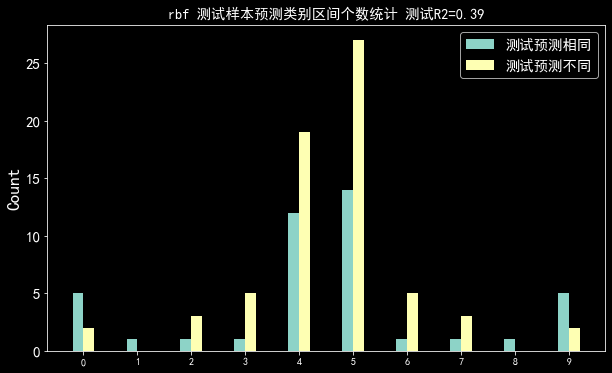

In [20]:
# 绘制训练样本类别预测与目标分类的相同和不同的概率区别统计图
plt.style.use(plt.style.available[4])  #可以通过下标进行选择适合自己的样式
plt.rcParams['font.sans-serif'] = ['SimHei']  #指定默认字体,用来正常显示中文标签
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

id_test_no = clf.predict(x_test)[:] != y_test  #测试样本预测类别与测试目标类别不同的下标
id_test_ok = clf.predict(x_test)[:] == y_test  #测试样本预测类别与测试目标类别不同的下标
test_no = clf.predict_proba(x_test)[id_test_no]  #测试样本预测类别与测试目标类别不同的概率值
test_ok = clf.predict_proba(x_test)[id_test_ok]

# 绘制测试样本类别预测与目标分类的相同和不同的概率区别统计图
his_test_ok, _ = np.histogram(test_ok, bins=10)
his_test_no, _ = np.histogram(test_no, bins=10)
# 绘制图像
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6)
# plt.set_cmap('RdBu')
plt.set_cmap('jet')
x = np.arange(len(_) - 1)
w = 0.1
# 绘制多个bar在同一个图中, 这里需要控制width
plt.bar(x - 1 * w, height=his_test_ok, width=2 * w, align='center')  #测试样本预测相同
plt.bar(x + 1 * w, height=his_test_no, width=2 * w, align='center')  #测试样本预测不同
# 设置坐标轴的标签
ax1.yaxis.set_tick_params(labelsize=15)  # 设置y轴的字体的大小
ax1.set_xticks(x)  # 设置xticks出现的位置
# 设置坐标轴名称
ax1.set_ylabel("Count", fontsize='xx-large')
# 设置标题
ax1.set_title('%s 测试样本预测类别区间个数统计 测试R2=%.2f' % (clf.kernel, score_test), fontsize='x-large')
# 设置图例
plt.legend(('测试预测相同', '测试预测不同'), fontsize='x-large', loc='upper right')
plt.show()

In [21]:
print(y_train[:10])
print(y_test[:10])
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_train.ndim)
print(x_test[:5])
print(y_test_pred[:50])

[False False False  True  True  True  True False False  True]
[False False False  True False False  True False  True  True]
(159, 4)
(54, 4)
(159,)
1
[[ 0.229  0.243  0.419  0.244]
 [-0.505 -0.448 -0.329 -0.505]
 [ 0.97   0.768  0.506  0.371]
 [ 0.377  0.315  0.419  0.222]
 [ 0.218  0.035  0.3    0.148]]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False  True
  True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


In [22]:
print(y_test.shape)
print(y_test.sum())
print(y_test_pred.sum())

(54,)
18
52
